# Sentiment Analysis for Product Stocking: NLP Insights 

## Overview

Two big tech gints;iPhone and Google, seek to understand their user sentiments towards their products. This data science project focuses on leveraging Twitter sentiment analysis to gain insights into customer opinions and preferences regarding iPhone and Google products. By analyzing user sentiments, we aim to make informed stocking decisions that align with customer demand and enhance overall customer satisfaction. The project involves collecting Twitter data related to discussions, reviews, and mentions of iPhone and Google products, followed by preprocessing and sentiment analysis. The insights derived from this analysis will guide Best Buy in optimizing its product assortment and ensuring a strategic alignment with customer preferences.

# Problem Statement 

Apple and Google, two of the world's leading tech companies, heavily depend on public perception to maintain their market positions and customer trust. As consumers increasingly voice their opinions on platforms like Twitter, understanding these sentiments has become very paramount for brand management, product development, and customer engagement strategies. This has therefore led to the need to develop algorithms that can provide sentiments for various opinions from users.

## Objectives
The main objectives of this project are:

To apply text preprocessing and vectorization techniques to prepare the Twitter data for effective model training.

To develop a binary sentiment classifier to distinguish between positive and negative tweets, as a baseline.

To extend the model to a multiclass classifier, that includes the neutral class.

To evaluate classifier performance using appropriate metrics such as F1-score, precision and recall, particularly for imbalanced classes.

To provide actionable data-driven insights and recommendations.

## Data Understanding
In this step, we will explore the dataset to understand the kind of information it contains, the different features and their data types, as well as checking for things like missing values or unusual patterns. This will help us get a clear picture of the data before moving on to cleaning, preprocessing and vectorization.

The dataset contains the following features:

tweet_text: This is the actual content of the tweet. It is the main text input used for sentiment classification.

emotion_in_tweet_is_directed_at: This specifies the tatget of the emotion expressed in the tweet (e.g., Apple, Google)

is_there_an_emotion_directed_at_a_brand_or_product: This indicates whether the tweet expresses an emotion directed at a brand or product. It serves as the label for classification.

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import re
from string import punctuation

#scipy
from scipy.sparse import csr_matrix

#sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC

#xgboost
import xgboost as xgb

#nlkt
from nltk import FreqDist
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
import joblib

In [2]:
# Define color map for plots
# Import color map
import matplotlib.cm as cm
# Choose a predefined colormap
colormap = cm.coolwarm  # Choose a diverging colormap like 'coolwarm', 'RdBu', 'seismic', etc.

# Create a color array with a range of colors from the chosen colormap
color_array = [colormap(i) for i in range(20)]  # Choose 20 colors from the palette

# Set the default color cycle to the color array
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_array)

In [3]:
# Load data and check structure 
data = pd.read_csv('data/judge_1377884607_tweet_product_company.csv')
data

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
8716,Ipad everywhere. #SXSW {link},iPad,Positive emotion
8717,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
8718,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
8719,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [4]:
# Checking data structure
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8721 entries, 0 to 8720
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          8720 non-null   object
 1   emotion_in_tweet_is_directed_at                     3169 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  8721 non-null   object
dtypes: object(3)
memory usage: 204.5+ KB


# Data Cleaning

In [5]:
# Check missing values
data.isna().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5552
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [6]:
# Checking index of missing value in tweet column
data[data['tweet_text'].isna()].index

Int64Index([6], dtype='int64')

In [7]:
# Dropping the row above with missing value in tweet_text
data.drop(index=data[data['tweet_text'].isna()].index, inplace= True)

In [8]:
# Shorten column names
data.columns = ['tweet', 'brand_product', 'emotion']

In [9]:
# Change emotions to 'Positive', 'Negative', and 'Neutral'
data.loc[data['emotion'] == 'No emotion toward brand or product', 'emotion'] = 'Neutral'
data.loc[data['emotion'] == 'Positive emotion', 'emotion'] = 'Positive'
data.loc[data['emotion'] == 'Negative emotion', 'emotion'] = 'Negative'

In [10]:
# Checking value counts for brand_product column
data.brand_product.value_counts()

iPad                               910
Apple                              640
iPad or iPhone App                 451
Google                             412
iPhone                             288
Other Google product or service    282
Android App                         78
Android                             74
Other Apple product or service      34
Name: brand_product, dtype: int64

In [11]:
# Derive 'brand_product' from tweets to fill missing values in former column
categories = np.array(['iPad', 'Apple', 'iPad', 'iPhone', 'Google', 'Android'])
def fill_missing_brand_product(df, categories):
    for i, row in df.iterrows():
        if pd.isnull(row['brand_product']):
            for category in np.concatenate((categories, np.char.lower(categories))):
                if category in row['tweet']:
                    # Use .loc[] to assign values to DataFrame
                    data.loc[i, 'brand_product'] = category
                    break  # Break out of inner loop once a category is found
                    
                    
# Call the function and pass the DataFrame 'data' and 'categories'
fill_missing_brand_product(data, categories)

In [12]:
# Check missing values, again
data.isna().sum()

tweet              0
brand_product    787
emotion            0
dtype: int64

In [13]:
# Percentage missing data for brand_product column
787/len(data)

0.09025229357798165

In [14]:
# Drop rows with missing data
data.dropna(inplace= True)
data

,tweet,brand_product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive
...,...,...,...
8716,Ipad everywhere. #SXSW {link},iPad,Positive
8717,"Wave, buzz... RT @mention We interrupt your re...",google,Neutral
8718,"Google's Zeiger, a physician never reported po...",Google,Neutral
8719,Some Verizon iPhone customers complained their...,iPhone,Neutral


In [15]:
# Check for duplicate entries
data.duplicated().sum()

20

In [16]:
#Remove duplicates
data.drop_duplicates(inplace=True)

Neutral         4381
Positive        2845
Negative         543
I can't tell     144
Name: emotion, dtype: int64


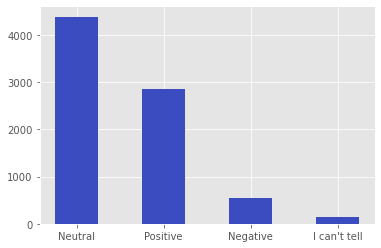

In [17]:
# Check classes for target feature
print(data.emotion.value_counts())
plt.bar(data.emotion.value_counts().index, data.emotion.value_counts(), width=.5);

The presence of "I can't tell" entries introduces ambiguity into the dataset, as they do not provide clear sentiment information. This ambiguity can impact the accuracy of sentiment analysis models, as it is uncertain whether these entries represent positive, negative, or neutral sentiments. Considering the relatively low proportion of such data, it was preferred to remove these entries to maintain the clarity and reliability of the dataset for more accurate sentiment analysis.

In [18]:
# Drop rows where emotion is 'I can't tell'
data.drop(index=data[data['emotion'] == 'I can\'t tell'].index, inplace= True)
data.reset_index(drop=True, inplace=True)
data

,tweet,brand_product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive
...,...,...,...
7764,Ipad everywhere. #SXSW {link},iPad,Positive
7765,"Wave, buzz... RT @mention We interrupt your re...",google,Neutral
7766,"Google's Zeiger, a physician never reported po...",Google,Neutral
7767,Some Verizon iPhone customers complained their...,iPhone,Neutral


In [19]:
# drop index 7768 with wierd characters since they cannot be decoded
data.drop(index=7768, inplace= True)

In [20]:
# View full text on sample tweets
data[['tweet']].sample(10).style.set_properties(**{'text-align': 'left'})

,tweet
2740,"Now lining up to get an iPad 2 at the Apple pop up store, not much of a long line up #sxsw"
6717,Apple'd :s > #sxsw #ipad2 @mention @mention @mention and Austin from Austin's pop up Apple store :))) {link}
364,Shipments daily - follow @mention #AppleATXdt 4 updates RT @mention Pop-up Apple Store seems to be out of pop-up iPad2s. #SXSW
2002,@mention check the photo feed from Apple store #SXSW {link} thanks to @mention @mention @mention.
3156,"nice! having fun? RT @mention At #SXSW with a thirsty gadget? Using @mention Charge Anywhere for my iPhone, happy to share some juice."
3195,New @mention for iPhone+Android.. No more service fees! Booyah #SXSW #GitChoCocktailOn
2722,Navigating a crowded party sucks. But its way worse when everyone walks around with their face in their iPhone. #sxsw #adpeopleproblems
4087,"Loved @mention Hangover Breakfast. Awesome swag, yummy food & rockin tunes! Stoked about my Griffin cordless iphone charger! #SXSW"
633,"more that just location, PixieEngine! RT @mention Google says the future is location, location, location: {link} #SXSW #CNN"
7511,"Our interview w Marissa Mayer from #SXSW on Google 3.0, how working for Larry will be different than working for Eric {link}"


# Train test split

In [21]:
#Perform a train test split on data
X = data[['tweet', 'brand_product']]
y = data['emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 1)
X_train

,tweet,brand_product
4226,"In the Google keynote, Marissa Meyer and some ...",Google
5953,RT @mention Who is flying to #SXSW and wants s...,iPhone
2532,Ha! Another mention for Apple Store: {link} - ...,Apple
2481,;-) RT @mention @mention The geeks need somewh...,iPad
2652,This stuff is great. Love seeing how these guy...,Other Google product or service
...,...,...
905,Love it . RT @mention From #Apple to Naomi Cam...,Apple
5192,RT @mention I hope everyone has an awesome wee...,Apple
3980,Apple Opening Pop-Up Store in Austin (Sixth &a...,iPad
235,"#technews Apple heads to SXSW, sets up tempora...",iPad


# Data preprocessing

In [22]:
# Function to remove tweet handles(words that start with @), HTML tags and URLs in tweets
def remove_html_urls_mentions(input_text):
    # Remove HTML tags
    pattern_html = re.compile('<.*?>')
    text = pattern_html.sub(r'', input_text)
    
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    
    # Remove Twitter usernames (mentions)
    text = re.sub(r'@\w+\s*', '', text)
    
    # Remove 'RT' (Retweet terms)
    text = re.sub(r'\bRT\b', '', text)
    
    # Remove words within curly braces {} and the braces themselves
    text = re.sub(r'\{[^}]*\}', '', text)
    
    # Remove words within square brackets [] and the brackets themselves
    text = re.sub(r'\[[^]]*\]', '', text)
    
    # Remove words within parentheses () and the parentheses themselves
    text = re.sub(r'\([^)]*\)', '', text)
    
    # Define the pattern to match any non-alphanumeric characters
    pattern = r'[^a-zA-Z0-9\s]'  # This pattern matches any character that is not a letter, digit, or whitespace

    # Replace all non-alphanumeric characters with an empty string
    cleaned_text = re.sub(pattern, '', text)
    
    return cleaned_text

In [23]:
# Function to encode emojis
def encode_emojis(text):
    """
    Encode emojis in text using Unicode.

    Parameters:
    text (str): Input text containing emojis.

    Returns:
    str: Text with emojis encoded using Unicode.
    """
    # Encode emojis using Unicode escape sequences
    emoji_encoded_text = text.encode('unicode-escape').decode('utf-8')
    
    return emoji_encoded_text

In [24]:
# Clean tweets for X_train data
X_train['cleaned_tweet'] = X_train['tweet'].apply(lambda text: encode_emojis(remove_html_urls_mentions(text)))
X_train = X_train[['tweet', 'cleaned_tweet', 'brand_product']].copy()
X_train

<ipython-input-24-2508839b6c1a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['cleaned_tweet'] = X_train['tweet'].apply(lambda text: encode_emojis(remove_html_urls_mentions(text)))


,tweet,cleaned_tweet,brand_product
4226,"In the Google keynote, Marissa Meyer and some ...",In the Google keynote Marissa Meyer and some o...,Google
5953,RT @mention Who is flying to #SXSW and wants s...,Who is flying to SXSW and wants some free mil...,iPhone
2532,Ha! Another mention for Apple Store: {link} - ...,Ha Another mention for Apple Store Temporar...,Apple
2481,;-) RT @mention @mention The geeks need somewh...,The geeks need somewhere downtown to line up...,iPad
2652,This stuff is great. Love seeing how these guy...,This stuff is great Love seeing how these guys...,Other Google product or service
...,...,...,...
905,Love it . RT @mention From #Apple to Naomi Cam...,Love it From Apple to Naomi Campbell popup s...,Apple
5192,RT @mention I hope everyone has an awesome wee...,I hope everyone has an awesome weekend at SXS...,Apple
3980,Apple Opening Pop-Up Store in Austin (Sixth &a...,Apple Opening PopUp Store in Austin for SXSW ...,iPad
235,"#technews Apple heads to SXSW, sets up tempora...",technews Apple heads to SXSW sets up temporary...,iPad


In [25]:
# Clean tweets for X_test data
X_test['cleaned_tweet'] = X_test['tweet'].apply(lambda text: encode_emojis(remove_html_urls_mentions(text)))
X_test = X_test[['tweet', 'cleaned_tweet', 'brand_product']].copy()
X_test

<ipython-input-25-e7728ed4aaf0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['cleaned_tweet'] = X_test['tweet'].apply(lambda text: encode_emojis(remove_html_urls_mentions(text)))


,tweet,cleaned_tweet,brand_product
3192,the @mention booth is up and ready for the #sx...,the booth is up and ready for the sxsw tradesh...,Android
605,@mention iPhone. Clearly. Positively. Happily...,iPhone Clearly Positively Happily SXSW,iPhone
5027,RT @mention Google tested 41 shades of blue fo...,Google tested 41 shades of blue for link colo...,Google
7414,Google &quot;product gatekeeper&quot; Marissa ...,Google quotproduct gatekeeperquot Marissa Maye...,Google
311,will this be another google wave? RT @mention ...,will this be another google wave We interrupt...,google
...,...,...,...
2753,@mention getting his new iPad at the #sxsw fla...,getting his new iPad at the sxsw flash apple s...,iPad
6041,Hotpot #google #marissameyer what is next #Cle...,Hotpot google marissameyer what is next Clevel...,google
5954,"RT @mention Who said IPAD photos? Apple Store,...",Who said IPAD photos Apple Store SXSW,Apple
5706,RT @mention RT: @mention With 150 million mobi...,With 150 million mobile users on Google maps...,Google


## Exploratory Data Analysis

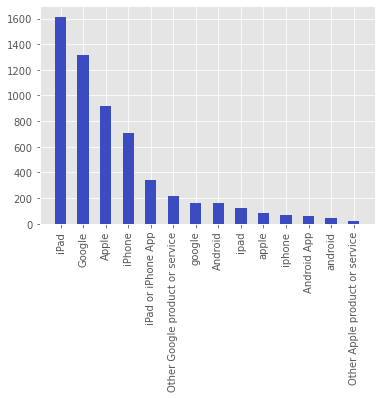

In [26]:
# EDA
X_train['brand_product'].value_counts()
plt.bar(X_train['brand_product'].value_counts().index, X_train['brand_product'].value_counts(), width=.5)
plt.xticks(rotation=90);

The tweets encompass various brands falling under Apple and Google products and services. We will aggregate them under these two main brands for analysis.

In [27]:
# Merge brand_column into only two categories: apple and google brands
Apple = ['iPad', 'Apple', 'iPhone', 'iPad or iPhone App', 'ipad', 'apple', 'iphone', 'Other Apple product or service']
Google = ['Google', 'google', 'Other Google product or service', 'Android', 'Android App', 'android']

def brand_category(X):
    for index, row in X.iterrows():
        if row['brand_product'] in Apple:
            X.at[index, 'brand_product'] = 'Apple'
        elif row['brand_product'] in Google:
            X.at[index, 'brand_product'] = 'Google'
    
    return X

# Call function on X_train data
X_train = brand_category(X_train)

In [28]:
# Call function on X_test data
X_test = brand_category(X_test)

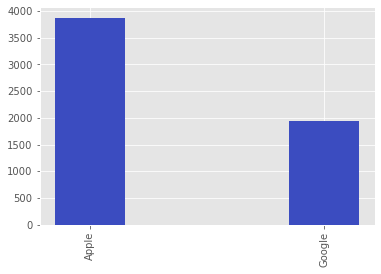

In [29]:
# Re-check brand_product column
X_train['brand_product'].value_counts()
plt.bar(X_train['brand_product'].value_counts().index, X_train['brand_product'].value_counts(), width=.3)
plt.xticks(rotation=90);

The number of tweets related to Apple was double that of those concerning Google.

In [30]:
# Function to tokenize and remove stopwords and punctuation
def process_tweet(tweet):
    tweet = tweet.lower() #convert tweet to lowercase
    # Define a regular expression pattern to match words including apostrophes
    pattern = r"\b\w+(?:'\w+)?\b"
    # Create a RegexpTokenizer with the defined pattern
    tokenizer = RegexpTokenizer(pattern)
    # Tokenize tweet
    tokens = tokenizer.tokenize(tweet)
    tokens = [token for token in tokens if token not in stopwords.words('english') 
              and token not in punctuation]                                    #remove stopwords and punctuations
    return tokens

# Apply function on X_train and X_test data
X_train['tokenized_tweets'] = X_train['cleaned_tweet'].apply(process_tweet)
X_test['tokenized_tweets'] = X_test['cleaned_tweet'].apply(process_tweet)

In [31]:
# Change columns arrangements
X_train = X_train[['tweet', 'cleaned_tweet', 'tokenized_tweets', 'brand_product']]
X_test = X_test[['tweet', 'cleaned_tweet', 'tokenized_tweets', 'brand_product']]

In [32]:
# Generate Frequency distribution
FreqDist(X_train['tokenized_tweets'].explode())

FreqDist({'sxsw': 6053, 'ipad': 1716, 'google': 1565, 'apple': 1423, 'iphone': 1061, 'store': 985, 'new': 752, '2': 739, 'austin': 601, 'app': 544, ...})

##### Top 20 tokens distribution

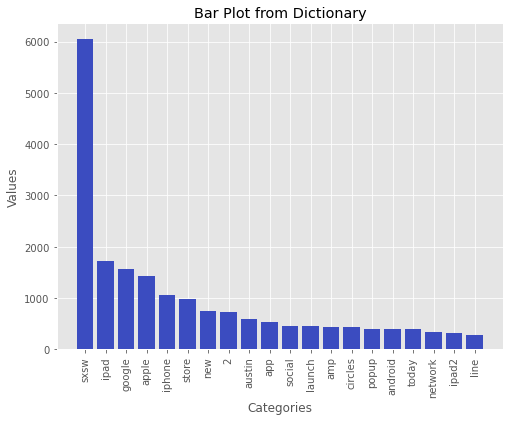

In [33]:
# Extract top 20 tokens and their values 
top_20 = FreqDist(X_train['tokenized_tweets'].explode()).most_common(20)
categories, values = zip(*top_20)

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(categories, values)
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Bar Plot from Dictionary')
plt.xticks(rotation=90)
plt.show()

Significantly, several tokens within the top 20 are directly associated with prominent brands like Google and Apple, including "android," "apple," "iPad," and "store." Moreover, the token with the highest frequency, "sxsw," pertains to a notable tech event. 

##### Token distribution by brand [@Top 20]

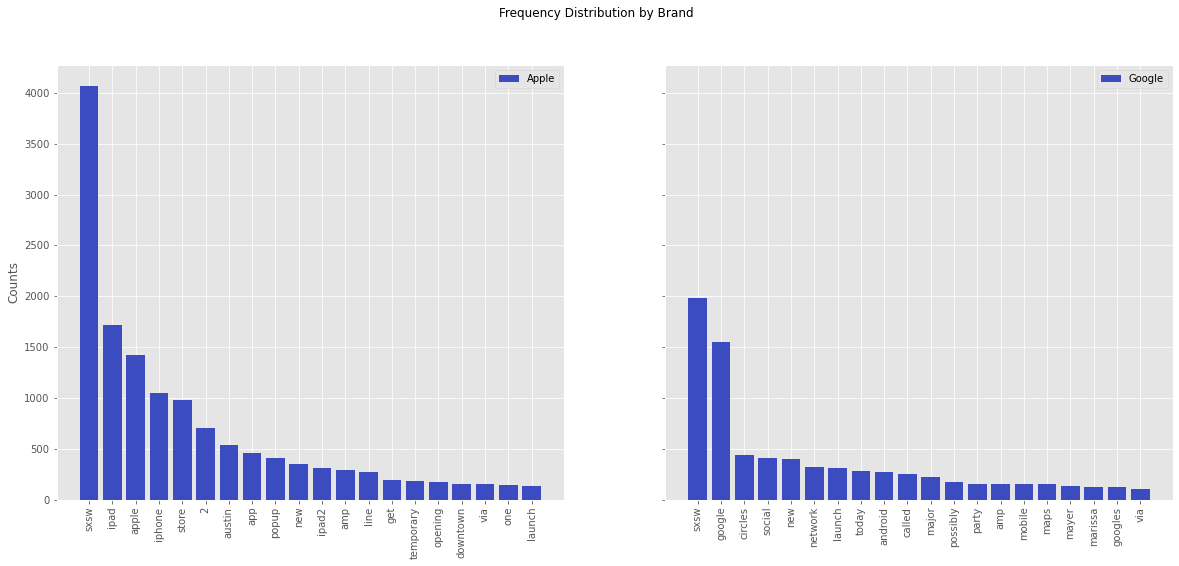

In [34]:
#check distribution by brand category
for_eda = pd.concat([X_train,y_train], axis= 1)
apple = for_eda[for_eda['brand_product'] == 'Apple']
google = for_eda[for_eda['brand_product'] == 'Google']

# Extract top 20 tokens and their values for apple brand
apple_top_20 = FreqDist(apple['tokenized_tweets'].explode()).most_common(20)
apple_categories, apple_values = zip(*apple_top_20)

# Extract top 20 tokens and their values for google brand
google_top_20 = FreqDist(google['tokenized_tweets'].explode()).most_common(20)
google_categories, google_values = zip(*google_top_20)

# Create a bar plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), sharey=True) 
axes[0].bar(apple_categories, apple_values, label='Apple')
axes[1].bar(google_categories, google_values, label='Google')
axes[0].set_ylabel('Counts')
fig.suptitle('Frequency Distribution by Brand')
axes[0].set_xticks(range(len(apple_categories)))
axes[0].set_xticklabels(apple_categories, rotation=90) 
axes[1].set_xticks(range(len(google_categories)))
axes[1].set_xticklabels(google_categories, rotation=90)
# Set legends on the axes
axes[0].legend()
axes[1].legend()

plt.show()

##### Emotions/Sentiments class distribution by brand

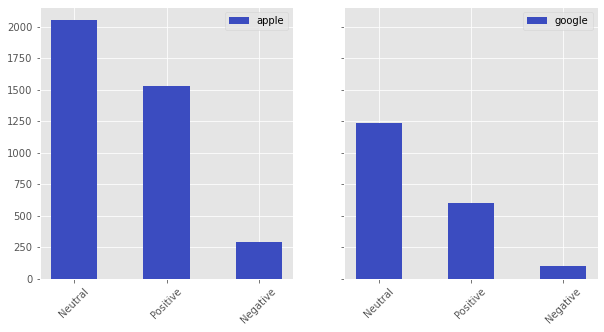

In [35]:
# Sentiments by brand
fig, ax = plt.subplots(nrows=1, ncols= 2, figsize= (10, 5), sharey= True)
ax[0].bar(apple['emotion'].value_counts().index, apple['emotion'].value_counts(), width= .5, label='apple');
ax[1].bar(google['emotion'].value_counts().index, google['emotion'].value_counts(), width= .5, label= 'google')
ax[0].legend()
ax[1].legend()

for axis in ax:
    axis.tick_params(axis='x', rotation=45)
    
plt.show()

The prevailing sentiment across both brands was predominantly neutral, followed by positive and then negative sentiments.

##### Token distribution by Emotions/Sentiments class

In [36]:
### Check token distribution based on emotion
positive_emotions_data = for_eda[for_eda['emotion'] == 'Positive']
negative_emotions_data = for_eda[for_eda['emotion'] == 'Negative']

# Extract top 20 tokens and their values for apple brand
positive_top_20 = FreqDist(positive_emotions_data['tokenized_tweets'].explode()).most_common(20)
positive_categories, positive_values = zip(*positive_top_20)

# Extract top 20 tokens and their values for google brand
negative_top_20 = FreqDist(negative_emotions_data['tokenized_tweets'].explode()).most_common(20)
negative_categories, negative_values = zip(*negative_top_20)

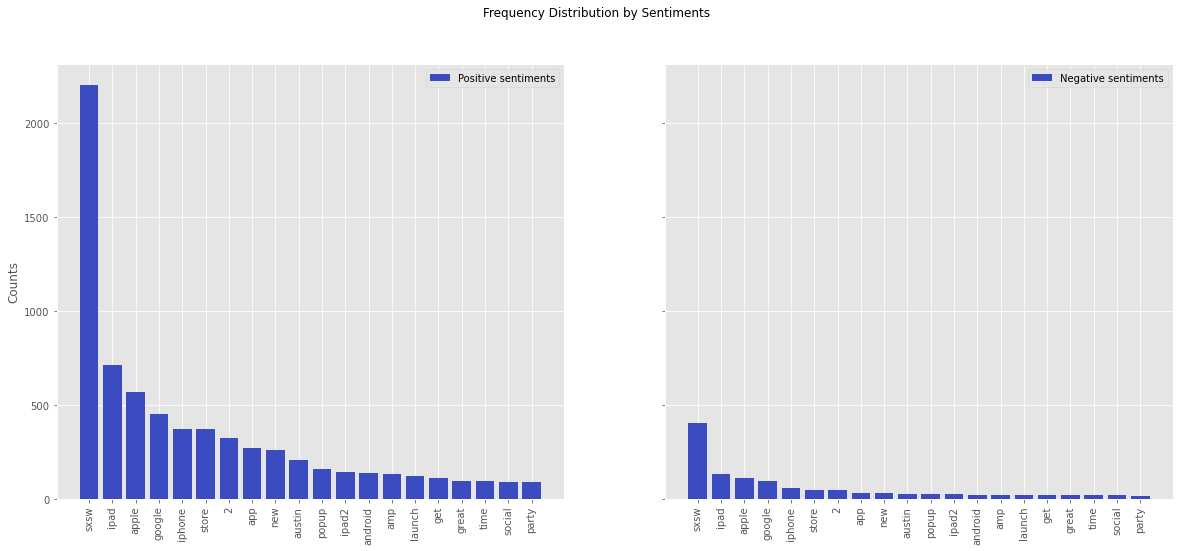

In [37]:
# Create a bar plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), sharey=True) 
axes[0].bar(positive_categories, positive_values, label='Positive sentiments')
axes[1].bar(negative_categories, negative_values, label='Negative sentiments')
axes[0].set_ylabel('Counts')
fig.suptitle('Frequency Distribution by Sentiments')
axes[0].set_xticks(range(len(positive_categories)))
axes[0].set_xticklabels(positive_categories, rotation=90) 
axes[1].set_xticks(range(len(positive_categories)))
axes[1].set_xticklabels(positive_categories, rotation=90)
# Set legends on the axes
axes[0].legend()
axes[1].legend()

plt.show()

## Feature Engineering